# M1 Closure: Vanishing Gradient and Activation Analysis

**Closing Milestone 1 by understanding sigmoid saturation, vanishing gradients, and why alternative activations emerged.**

This notebook covers:
1. Visualizing the sigmoid function
2. Sigmoid derivative and its behavior
3. Gradient shrinkage demonstration
4. Simulated training with extreme weights
5. Multi-layer vanishing gradient preview
6. Sigmoid vs ReLU comparison
7. Summary and journal reflection

*NumPy and Matplotlib only. Clean and educational.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
# Section 1: Visualizing Sigmoid

The sigmoid function maps any real number $z$ to $(0, 1)$:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Key behavior:** As $|z|$ becomes large, outputs **saturate**—they approach 0 or 1 and change very slowly. When $z \approx 0$, the model is near the decision boundary and outputs around 0.5.

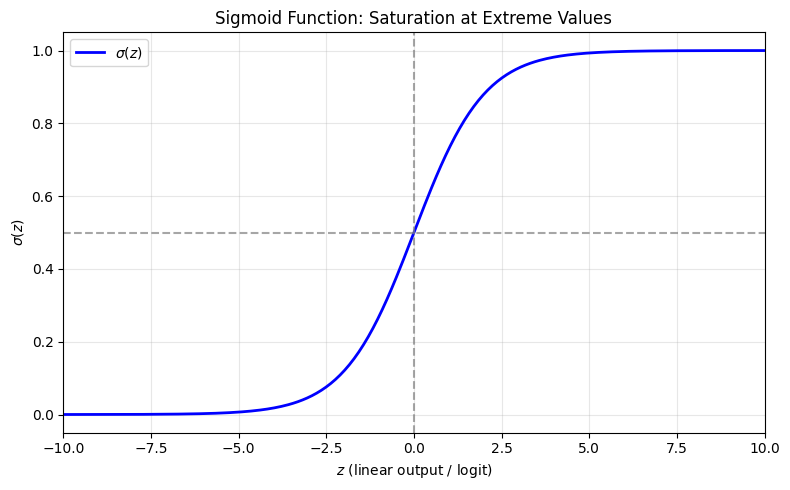

Saturation: Large |z| → output near 0 or 1. Learning signal weakens.


In [2]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

z = np.linspace(-10, 10, 300)
s = sigmoid(z)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(z, s, 'b-', linewidth=2, label=r'$\sigma(z)$')
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel(r'$z$ (linear output / logit)')
ax.set_ylabel(r'$\sigma(z)$')
ax.set_title('Sigmoid Function: Saturation at Extreme Values')
ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 1.05)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Saturation: Large |z| → output near 0 or 1. Learning signal weakens.')

**Reflection Prompt:** What happens to learning when predictions are extremely confident (near 0 or 1)?

---
# Section 2: Sigmoid Derivative

The derivative of sigmoid has a compact form:

$$\sigma'(z) = \sigma(z)(1 - \sigma(z))$$

This is **maximized at $z = 0$** (value 0.25) and **approaches 0** as $|z| \to \infty$. When a neuron saturates, its gradient magnitude shrinks.

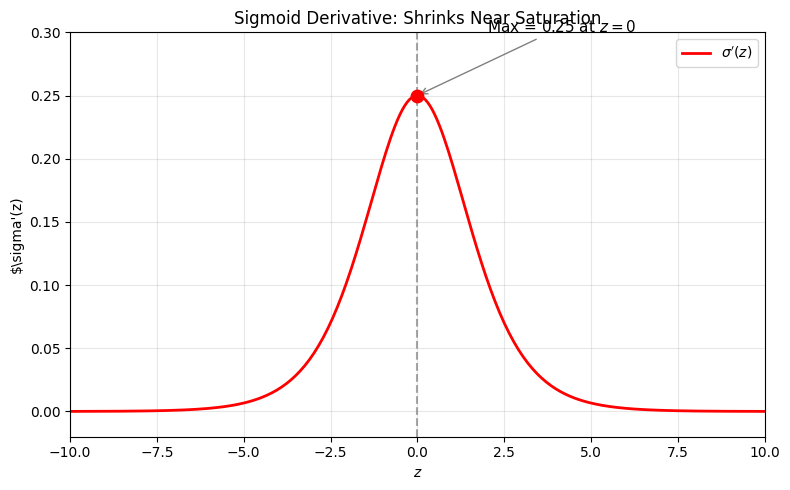

Peak at z=0: strongest gradient at the decision boundary.


In [3]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

z = np.linspace(-10, 10, 300)
ds = sigmoid_derivative(z)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(z, ds, 'r-', linewidth=2, label=r"$\sigma'(z)$")
ax.axvline(0, color='gray', linestyle='--', alpha=0.7)
ax.scatter([0], [0.25], color='red', s=80, zorder=5)
ax.annotate(r'Max = 0.25 at $z=0$', xy=(0, 0.25), xytext=(2, 0.3),
            fontsize=11, arrowprops=dict(arrowstyle='->', color='gray'))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r"$\sigma'(z)")
ax.set_title('Sigmoid Derivative: Shrinks Near Saturation')
ax.set_xlim(-10, 10)
ax.set_ylim(-0.02, 0.3)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Peak at z=0: strongest gradient at the decision boundary.')

**Reflection Prompt:** Why is the derivative highest at the decision boundary?

---
# Section 3: Gradient Shrinkage Demonstration

We compute sigmoid and its derivative at several $z$ values. At $z=0$, the derivative is large; at $z=\pm 10$, it is nearly zero. This directly affects how much weights are updated during gradient descent.

In [4]:
z_vals = np.array([-10, -5, -2, 0, 2, 5, 10])
s_vals = sigmoid(z_vals)
ds_vals = sigmoid_derivative(z_vals)

print('z         | sigmoid(z)  | sigmoid\'(z)')
print('-' * 45)
for i in range(len(z_vals)):
    print(f'{z_vals[i]:+6.1f}    | {s_vals[i]:.8f}  | {ds_vals[i]:.8f}')

print('\n--- Interpretation ---')
print('z=0:   derivative ≈ 0.25 (large) → strong weight updates')
print('z=10:  derivative ≈ 0  (tiny)   → negligible updates')
print('z=-10: derivative ≈ 0  (tiny)   → negligible updates')

print('\nWeight update ∝ gradient; gradient ∝ σ\'(z). When σ\'(z)≈0, updates stall.')

z         | sigmoid(z)  | sigmoid'(z)
---------------------------------------------
 -10.0    | 0.00004540  | 0.00004540
  -5.0    | 0.00669285  | 0.00664806
  -2.0    | 0.11920292  | 0.10499359
  +0.0    | 0.50000000  | 0.25000000
  +2.0    | 0.88079708  | 0.10499359
  +5.0    | 0.99330715  | 0.00664806
 +10.0    | 0.99995460  | 0.00004540

--- Interpretation ---
z=0:   derivative ≈ 0.25 (large) → strong weight updates
z=10:  derivative ≈ 0  (tiny)   → negligible updates
z=-10: derivative ≈ 0  (tiny)   → negligible updates

Weight update ∝ gradient; gradient ∝ σ'(z). When σ'(z)≈0, updates stall.


---
# Section 4: Simulated Training With Extreme Weights

Initialize the model with **very large weights**. Predictions saturate (all near 0 or 1), gradients become tiny, and training slows dramatically. We track gradient norm over iterations.

First 5 predictions (saturated): [1. 1. 1. 0. 0.]
Gradient norm at start: 0.004040
Gradient norm at end:   0.003884


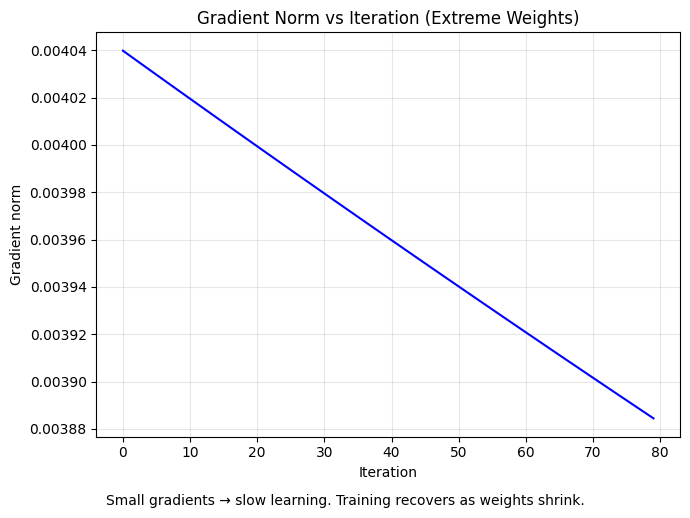


With extreme weights, gradients stay very small until weights shrink.


In [8]:
from utils import generate_linearly_separable, train_test_split
from model import LogisticRegression

np.random.seed(42)
X, y = generate_linearly_separable()
X_train, y_train, X_test, y_test = train_test_split(X, y)

model = LogisticRegression(lr=0.1, epochs=80, n_features=2)
model.init_training_history()
model.weights = np.array([8.0, 8.0])   # Extreme weights
model.bias = -10.0

for _ in range(model.epochs):
    z, y_pred = model.forward(X_train)
    model.update_weights(X_train, y_train, y_pred)

print('First 5 predictions (saturated):', model.forward(X_train)[1][:5].round(4))
print('Gradient norm at start:', f'{model.grad_norms[0]:.6f}')
print('Gradient norm at end:  ', f'{model.grad_norms[-1]:.6f}')

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(model.grad_norms, 'b-', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Gradient norm')
ax.set_title('Gradient Norm vs Iteration (Extreme Weights)')
ax.grid(True, alpha=0.3)
fig.text(0.5, -0.02, 'Small gradients → slow learning. Training recovers as weights shrink.', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

print('\nWith extreme weights, gradients stay very small until weights shrink.')

---
# Section 5: Multi-Layer Preview (Vanishing Gradient Effect)

Simulate two sigmoid layers:

$$a = \sigma(W_1 x), \quad y = \sigma(W_2 a)$$

By the chain rule, the gradient w.r.t. weights multiplies derivatives from each layer. Each saturated layer contributes a factor $\ll 1$, so the product shrinks **exponentially**.

In [6]:
x = 1.0
W1, W2 = 5.0, 5.0

z1 = W1 * x
a = sigmoid(z1)
z2 = W2 * a
y = sigmoid(z2)

ds1 = sigmoid_derivative(z1)
ds2 = sigmoid_derivative(z2)

chain_product = ds1 * ds2

print('Layer 1: z1 =', z1, ', a =', round(a, 6), ', sigmoid\'(z1) =', round(ds1, 8))
print('Layer 2: z2 =', round(z2, 4), ', y =', round(y, 6), ', sigmoid\'(z2) =', round(ds2, 8))
print('\nChain product (sigmoid\'1 × sigmoid\'2):', chain_product)
print('\nThis factor multiplies gradients. With many layers, it vanishes.')

Layer 1: z1 = 5.0 , a = 0.993307 , sigmoid'(z1) = 0.00664806
Layer 2: z2 = 4.9665 , y = 0.993081 , sigmoid'(z2) = 0.00687116

Chain product (sigmoid'1 × sigmoid'2): 4.567988046805685e-05

This factor multiplies gradients. With many layers, it vanishes.


---
# Section 6: Compare Sigmoid vs ReLU

ReLU: $f(z) = \max(0, z)$. Derivative: 1 for $z > 0$, 0 for $z < 0$. In the positive region, gradients do **not** shrink—this alleviates vanishing gradient for deep networks.

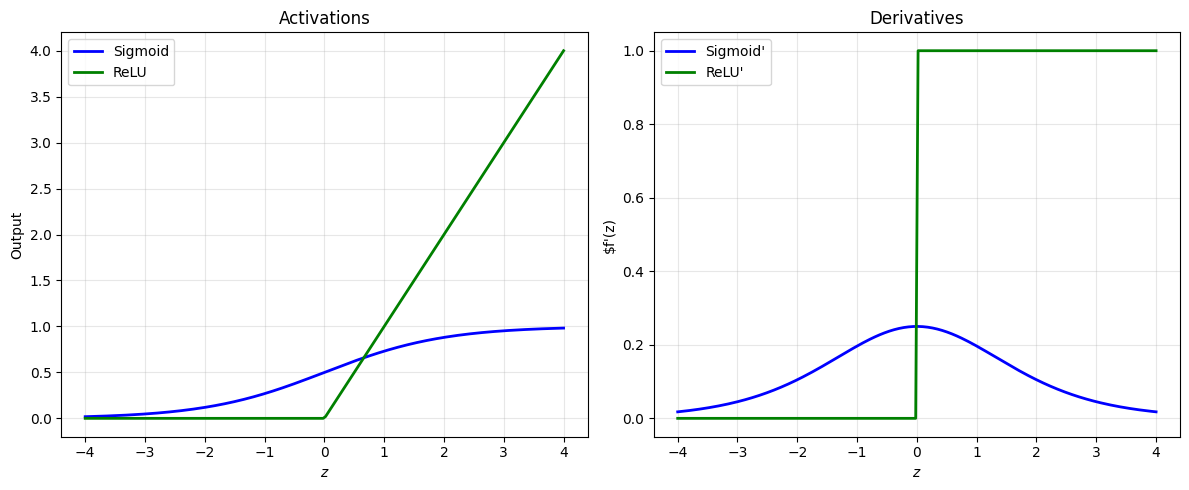

ReLU: derivative = 1 for z>0 → no vanishing in positive region.


In [7]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

z = np.linspace(-4, 4, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(z, sigmoid(z), 'b-', label='Sigmoid', linewidth=2)
axes[0].plot(z, relu(z), 'g-', label='ReLU', linewidth=2)
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel('Output')
axes[0].set_title('Activations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(z, sigmoid_derivative(z), 'b-', label=r"Sigmoid'", linewidth=2)
axes[1].plot(z, relu_derivative(z), 'g-', label=r"ReLU'", linewidth=2)
axes[1].set_xlabel(r'$z$')
axes[1].set_ylabel(r"$f'(z)")
axes[1].set_title('Derivatives')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('ReLU: derivative = 1 for z>0 → no vanishing in positive region.')

---
# Section 7: Summary

- **Sigmoid saturates** at large $|z|$; outputs approach 0 or 1.
- **Derivative shrinks** near saturation; max 0.25 at $z=0$.
- **BCE cancels sigmoid derivative** in logistic regression (single layer), so training works.
- **In deeper networks**, each layer multiplies small derivatives; gradients vanish exponentially.
- **ReLU** keeps derivative = 1 for $z>0$, avoiding vanishing in the positive region.

---
# Section 8: Journal Reflection Questions

Copy these into your learning journal:

1. **Why does the sigmoid derivative cause vanishing gradient?**

2. **Why was logistic regression still trainable despite using sigmoid?**

3. **What changes when stacking multiple sigmoid layers?**

4. **How does activation choice affect optimization geometry?**

5. **What conceptual shift occurred from Day 1 to Day 3?**